# Import Library

In [1]:
!pip install keras-tuner

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.optimizers import adam_v2
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing import image
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  del sys.path[0]


# Import Dataset

In [3]:
train = pd.read_csv('../input/digit-recognizer/train.csv')
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test = pd.read_csv('../input/digit-recognizer/test.csv')
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Frequency of Target 

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Frequency of Digits')

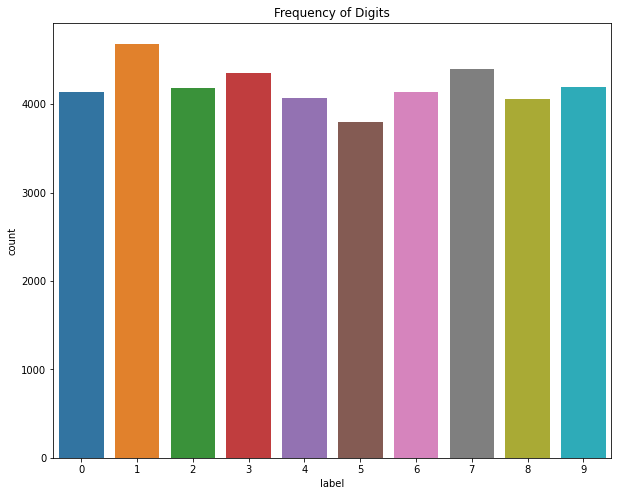

In [5]:
plt.figure(figsize=(10, 8))
sns.countplot(train.label)
plt.title('Frequency of Digits')

# Reshaping and Normalizing Data

In [6]:
xtrain = train.drop('label', axis=1)
ytrain = train['label']

In [7]:
xtrain = np.array(xtrain).reshape(-1, 28, 28, 1)
test = np.array(test).reshape(-1, 28, 28, 1)
xtrain = xtrain/255
test = test/255

# Display Image

(None, 7)

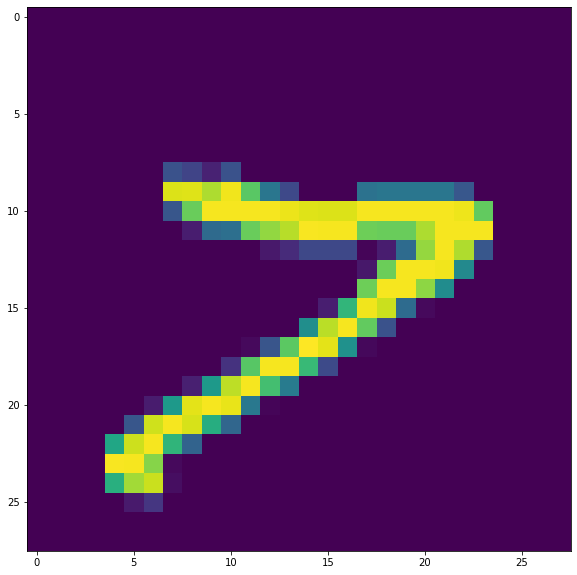

In [8]:
def display_digit(img):
    plt.figure(figsize = (10, 10))
    plt.imshow(img)
    

display_digit(xtrain[1100]), ytrain[1100]

# Splitting Dataset

In [9]:
from sklearn.model_selection import train_test_split #to split our dataset
xtrain, xtest, ytrain, ytest = train_test_split(xtrain, ytrain, test_size=0.1, random_state=101)

# Custom CNN Keras-Tuner Model

In [10]:
def cnn_model(hp):
    model = Sequential()
    
    model.add(Conv2D(
    filters = hp.Int('conv1_filter', min_value=16, max_value = 128, step=16),
    kernel_size=hp.Choice('conv1_kernel', values = [3,5]),
    activation='relu',
    input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=hp.Choice('conv1_pool', values = [2, 4])))
    model.add(BatchNormalization(axis = -1))
    
    model.add(Conv2D(
    filters = hp.Int('conv2_filter', min_value=16, max_value = 128, step=16),
    kernel_size=hp.Choice('conv2_kernel', values = [3,5]),
    activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization(axis = -1))
    
#     model.add(Conv2D(
#     filters = hp.Int('conv3_filter', min_value=16, max_value = 128, step=16),
#     kernel_size=hp.Choice('conv3_kernel', values = [3,5]),
#     activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(BatchNormalization(axis = -1))
    
    
    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=adam_v2.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

In [11]:
tuner_search=RandomSearch(cnn_model,
                          objective='val_accuracy',
                          max_trials=5,directory='output',project_name="Digit Recognizer")

2022-11-12 20:58:50.984165: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 20:58:51.130589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 20:58:51.131398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 20:58:51.133004: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
tuner_search.search(xtrain,ytrain,epochs=3, validation_split=0.1)

Trial 5 Complete [00h 00m 21s]
val_accuracy: 0.9801587462425232

Best val_accuracy So Far: 0.9849206209182739
Total elapsed time: 00h 01m 15s


# Extracting Best Model

In [13]:
model = tuner_search.get_best_models(num_models=1)[0]

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 96)        2496      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 12, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          38416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 16)          64        
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

# Training Again

In [15]:
model.fit(xtrain, ytrain, epochs=10, validation_split=0.1, initial_epoch=3)

Epoch 4/10
1064/1064 [==============================] - 4s 3ms/step - loss: 0.0309 - accuracy: 0.9904 - val_loss: 0.0689 - val_accuracy: 0.9786
Epoch 5/10
1064/1064 [==============================] - 3s 3ms/step - loss: 0.0256 - accuracy: 0.9914 - val_loss: 0.0561 - val_accuracy: 0.9854
Epoch 6/10
1064/1064 [==============================] - 3s 3ms/step - loss: 0.0185 - accuracy: 0.9943 - val_loss: 0.0806 - val_accuracy: 0.9783
Epoch 7/10
1064/1064 [==============================] - 4s 4ms/step - loss: 0.0174 - accuracy: 0.9942 - val_loss: 0.0451 - val_accuracy: 0.9862
Epoch 8/10
1064/1064 [==============================] - 3s 3ms/step - loss: 0.0129 - accuracy: 0.9957 - val_loss: 0.0558 - val_accuracy: 0.9862
Epoch 9/10
1064/1064 [==============================] - 3s 3ms/step - loss: 0.0121 - accuracy: 0.9959 - val_loss: 0.0573 - val_accuracy: 0.9860
Epoch 10/10
1064/1064 [==============================] - 3s 3ms/step - loss: 0.0111 - accuracy: 0.9966 - val_loss: 0.0696 - val_accuracy

# Predict Test dataset

In [16]:
#import submission file
submission = pd.read_csv('../input/digit-recognizer/sample_submission.csv')
submission.head()

#predict test dataset
ypred = model.predict(test)
ytest = np.argmax(ypred,axis=1)

#assigning result to submission file
submission['Label'] = ytest
submission.to_csv('submission.csv', index=False)